# Step 2 - Feature enginering

Step 1. [Data exploration](/notebooks/forex/mark2/1_data_explore.ipynb)

Step 2. **Feature engineering**

Step 3. [Data training and models evaluation](/notebooks/forex/mark2/3_training_and_optimazation.ipynb)

SYMBOL: 1 Hour EURUSD

Indicator:
* RSI(14)
* STOCH(9,6)
* STOCHRSI(14)
* ADX(14)
* Williams %R (0 - -100)
* CCI(14)
* Ultimate Oscillator


# import

In [48]:
from math import sqrt
from datetime import datetime
from dateutil.relativedelta import relativedelta
import talib as ta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Set default font size
plt.rcParams['font.size'] = 24

# Internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize

csv_path = 'data/EURUSD_Candlestick_1_Hour_ASK_01.05.2017-18.05.2019_cleaned.csv'

# Load cleaned data

In [5]:
# load csv
df = pd.read_csv(csv_path,
                 header=0,
                 names=['time', 'open', 'high', 'low', 'close', 'volume', 
                        'hour', 'volatility'],
                 parse_dates=['time'])
df = df.set_index('time')
print('Row count = %d' % len(df))
df.head(5)

Row count = 12761


,open,high,low,close,volume,hour,volatility
time,,,,,,,
2017-05-01 00:00:00,1.09062,1.09081,1.08998,1.08998,2590.4500,0,8.3
2017-05-01 01:00:00,1.08998,1.09010,1.08895,1.08931,3752.0701,1,11.5
2017-05-01 02:00:00,1.08931,1.08970,1.08924,1.08942,2384.3999,2,4.6
2017-05-01 03:00:00,1.08941,1.08950,1.08915,1.08935,914.2400,3,3.5
2017-05-01 04:00:00,1.08935,1.08940,1.08904,1.08912,1391.0900,4,3.6


# Calculate max profit and score each candle

In [14]:
# the max sell&buy profit during 1 hour

# function to calculate pips
def pip(price=None, _abs=False):

    pip_unit = 0.0001
    if price:
        price = float(price)
        if _abs:
            price = abs(price)
        return (price / pip_unit)

    return pip_unit

def max_profit(path, delta):
    parser = lambda time, high, low, close: (datetime.strptime(
        time, '%Y-%m-%d %H:%M:%S'), float(high), float(low), float(close))
    import csv

    with open(path) as tick:
        data = csv.reader(tick)
        data = list(data)
        length = len(data)
        result = []
        count = 0
        now = datetime.now()
        take_profit=5
        for index, row in enumerate(data):
            if index == 0:
                continue
            time, high, low, close = parser(row[0], row[2], row[3], row[4])
            start, end = time, time + delta
            max_sell, max_buy = 0, 0
            max_sell_count, max_buy_count = 0, 0
            itor = 1
            while start < end:
                i = index + itor
                if i >= length:
                    break
                ctime, chigh, clow, cclose = parser(data[i][0], data[i][2],
                                                    data[i][3], data[i][4])
                max_s = pip(clow - close)
                max_b = pip(chigh - close)
                if max_s < max_sell:
                    max_sell = max_s
                if max_s < 0:
                    max_sell_count += 1
                if max_b > max_buy:
                    max_buy = max_b
                if max_b > 0:
                    max_buy_count += 1

                itor += 1
                start = ctime
            result.append((time, max_buy, max_buy_count, max_sell,
                           max_sell_count))

            if not index % 10000:
                print(index)

    profit_df = pd.DataFrame(result,
                             columns=[
                                 'time', 'max_buy', 'max_buy_count',
                                 'max_sell', 'max_sell_count'
                             ])
    profit_df = profit_df.set_index('time')
    return profit_df

In [17]:
profit_df = max_profit(csv_path, relativedelta(hours=12))
profit_df.to_csv(
    'data/EURUSD_Candlestick_1_Hour_ASK_01.05.2017-18.05.2019_profit.csv',
    float_format='%.5f')

10000


In [18]:
# check score
profit_df = pd.read_csv(
    'data/EURUSD_Candlestick_1_Hour_ASK_01.05.2017-18.05.2019_profit.csv',
    header=0,
    names=[
        'time', 'max_buy', 'max_buy_count', 'max_sell', 'max_sell_count',
    ],
    parse_dates=['time'])
profit_df = profit_df.set_index('time')
profit_df.head()

,max_buy,max_buy_count,max_sell,max_sell_count
time,,,,
2017-05-01 00:00:00,22.4,4,-15.4,11
2017-05-01 01:00:00,29.1,10,-8.7,7
2017-05-01 02:00:00,29.9,9,-9.8,6
2017-05-01 03:00:00,30.6,10,-9.1,5
2017-05-01 04:00:00,32.9,11,-6.8,4


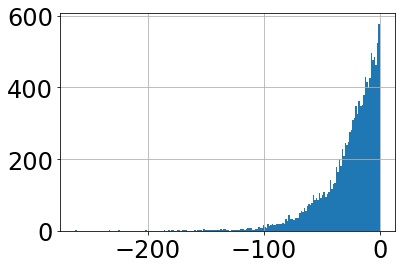

In [19]:
profit_df['max_sell'].hist(bins=200)

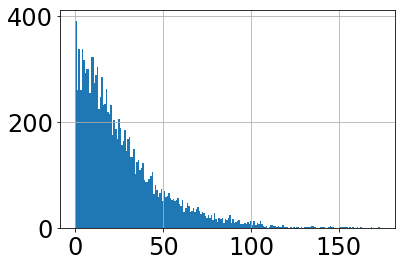

In [20]:
profit_df['max_buy'].hist(bins=200)

In [25]:
# get is_profit
take_profit = 40
stop_loss = 30
profit_df['is_buy_profit'] = ((profit_df['max_sell'] > -1 * stop_loss) &
                       (profit_df['max_buy'] > take_profit))

profit_df['is_sell_profit'] = ((profit_df['max_buy'] < stop_loss) &
                        (profit_df['max_sell'] < -1 * take_profit))

profit_df[profit_df['is_buy_profit'] == True].head()

,max_buy,max_buy_count,max_sell,max_sell_count,is_buy_profit,is_sell_profit
time,,,,,,
2017-05-03 21:00:00,51.0,12,-9.7,3,True,False
2017-05-03 22:00:00,51.7,12,-14.4,6,True,False
2017-05-03 23:00:00,52.7,12,-13.4,4,True,False
2017-05-04 00:00:00,54.3,12,-11.8,3,True,False
2017-05-04 01:00:00,48.0,12,-18.1,5,True,False


In [31]:
# percent of profit chance

data = ( profit_df[profit_df['is_buy_profit']==False],profit_df[profit_df['is_buy_profit']==True])
print('Buy profit')
print(f'Lose = {len(data[0])}')
print(f'Win = {len(data[1])}')


data = ( profit_df[profit_df['is_sell_profit']==False],profit_df[profit_df['is_sell_profit']==True])
print('\nSell profit')
print(f'Lose = {len(data[0])}')
print(f'Win = {len(data[1])}')


Buy profit
Lose = 10313
Win = 2448

Sell profit
Lose = 10387
Win = 2374


# Create feature

Here use indicators:
* RSI(14) [0, 100]
* STOCH(9,6) [0, 100]
* STOCHRSI(14) [0, 100]
* ADX(14) [0, 100]
* Williams %R [-100, 0]
* CCI(14) [-350, 350]
* Ultimate Oscillator [0, 100]

In [51]:
# RSI(14) [0, 100]
df['rsi'] = ta.RSI(df['close'], timeperiod=14)

# STOCH(9, 6) [0, 100]
df['stoch_slowk'], df['stoch_slowd'] = ta.STOCH(df['high'],
                                                df['low'],
                                                df['close'],
                                                fastk_period=9,
                                                slowk_period=6,
                                                slowk_matype=0,
                                                slowd_period=3,
                                                slowd_matype=0)
# STOCHRSI(14) [0, 100]
df['stochrsi_fastk'], df['stochrsi_fastd'] = ta.STOCHRSI(df['close'],
                                                         timeperiod=14,
                                                         fastk_period=9,
                                                         fastd_period=6,
                                                         fastd_matype=0)
# ADX(14) [0, 100]
df['adx'] = ta.ADX(df['high'], df['low'], df['close'], timeperiod=14)

# Williams %R [-100, 0]
df['williams_r'] = ta.WILLR(df['high'], df['low'], df['close'], timeperiod=14)

# CCI(14) [-350, 350]
df['cci'] = ta.CCI(df['high'], df['low'], df['close'], timeperiod=14)

# Ultimate Oscillator [0, 100]
df['ultosc'] = ta.ULTOSC(df['high'],
                      df['low'],
                      df['close'],
                      timeperiod1=6,
                      timeperiod2=12,
                      timeperiod3=24)

df.tail(5)

,open,high,low,close,volume,hour,volatility,rsi,stoch_slowk,stoch_slowd,stochrsi_fastk,stochrsi_fastd,adx,williams_r,cci,ultosc,hour_sin,hour_cos
time,,,,,,,,,,,,,,,,,,
2019-05-17 16:00:00,1.11651,1.11694,1.11640,1.11647,12190.32,16,5.4,40.018780,42.702966,41.511694,53.425355,59.635106,37.818436,-67.820069,-68.962511,52.411593,-0.866025,-5.000000e-01
2019-05-17 17:00:00,1.11646,1.11670,1.11614,1.11650,12731.28,17,5.6,40.327155,44.043035,42.945929,55.498303,63.421867,38.138280,-66.782007,-75.391017,51.015595,-0.965926,-2.588190e-01
2019-05-17 18:00:00,1.11649,1.11649,1.11593,1.11593,8851.12,18,5.6,36.488662,35.165826,40.637276,9.018390,48.258265,38.601178,-86.505190,-101.137162,42.509753,-1.000000,-1.836970e-16
2019-05-17 19:00:00,1.11593,1.11670,1.11592,1.11607,17097.71,19,7.8,38.048407,27.982369,35.730410,22.586885,36.402183,38.601848,-81.660900,-78.266760,38.942806,-0.965926,2.588190e-01
2019-05-17 20:00:00,1.11606,1.11613,1.11554,1.11582,4685.08,20,5.9,36.332498,27.232658,30.126951,7.659892,33.891076,38.930891,-90.311419,-121.555415,42.784882,-0.866025,5.000000e-01


# Indicator scale

In [52]:
# max cci
cci_scale = df['cci'].max()
if cci_scale > -1 * df['cci'].min():
    cci_scale = -1 * df['cci'].min()
print(cci_scale)

451.08447488569834


In [65]:
df['hour'].describe()
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['hour_sin'] = df['hour_sin'].round(5)
df['hour_cos'] = df['hour_cos'].round(5)
df.tail()

,open,high,low,close,volume,hour,volatility,rsi,stoch_slowk,stoch_slowd,stochrsi_fastk,stochrsi_fastd,adx,williams_r,cci,ultosc,hour_sin,hour_cos
time,,,,,,,,,,,,,,,,,,
2019-05-17 16:00:00,1.11651,1.11694,1.11640,1.11647,12190.32,16,5.4,40.018780,42.702966,41.511694,53.425355,59.635106,37.818436,-67.820069,-68.962511,52.411593,-0.86603,-0.50000
2019-05-17 17:00:00,1.11646,1.11670,1.11614,1.11650,12731.28,17,5.6,40.327155,44.043035,42.945929,55.498303,63.421867,38.138280,-66.782007,-75.391017,51.015595,-0.96593,-0.25882
2019-05-17 18:00:00,1.11649,1.11649,1.11593,1.11593,8851.12,18,5.6,36.488662,35.165826,40.637276,9.018390,48.258265,38.601178,-86.505190,-101.137162,42.509753,-1.00000,-0.00000
2019-05-17 19:00:00,1.11593,1.11670,1.11592,1.11607,17097.71,19,7.8,38.048407,27.982369,35.730410,22.586885,36.402183,38.601848,-81.660900,-78.266760,38.942806,-0.96593,0.25882
2019-05-17 20:00:00,1.11606,1.11613,1.11554,1.11582,4685.08,20,5.9,36.332498,27.232658,30.126951,7.659892,33.891076,38.930891,-90.311419,-121.555415,42.784882,-0.86603,0.50000


In [62]:
merged_df = pd.merge(df, profit_df, on='time')
merged_df.tail()

,open,high,low,close,volume,hour,volatility,rsi,stoch_slowk,stoch_slowd,...,cci,ultosc,hour_sin,hour_cos,max_buy,max_buy_count,max_sell,max_sell_count,is_buy_profit,is_sell_profit
time,,,,,,,,,,,,,,,,,,,,,
2019-05-17 16:00:00,1.11651,1.11694,1.11640,1.11647,12190.32,16,5.4,40.018780,42.702966,41.511694,...,-68.962511,52.411593,-0.86603,-0.50000,2.3,3,-9.3,4,False,False
2019-05-17 17:00:00,1.11646,1.11670,1.11614,1.11650,12731.28,17,5.6,40.327155,44.043035,42.945929,...,-75.391017,51.015595,-0.96593,-0.25882,2.0,1,-9.6,3,False,False
2019-05-17 18:00:00,1.11649,1.11649,1.11593,1.11593,8851.12,18,5.6,36.488662,35.165826,40.637276,...,-101.137162,42.509753,-1.00000,-0.00000,7.7,2,-3.9,2,False,False
2019-05-17 19:00:00,1.11593,1.11670,1.11592,1.11607,17097.71,19,7.8,38.048407,27.982369,35.730410,...,-78.266760,38.942806,-0.96593,0.25882,0.6,1,-5.3,1,False,False
2019-05-17 20:00:00,1.11606,1.11613,1.11554,1.11582,4685.08,20,5.9,36.332498,27.232658,30.126951,...,-121.555415,42.784882,-0.86603,0.50000,0.0,0,0.0,0,False,False


In [64]:
merged_df.to_csv(
    'data/EURUSD_Candlestick_1_Hour_ASK_01.05.2017-18.05.2019_featured.csv',
    float_format='%.5f')